STREAMING TRENDS ANALYSIS

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, to_date, lit, explode, split, count, trim
from pyspark.sql import Window

# 1. Initialize Spark Session
spark = SparkSession.builder.appName("NetflixPySparkAnalysis").getOrCreate()



In [2]:
# 2. Load Data (USING SAFER OPTIONS: quote, escape, multiLine)
# Ensure file_path is the correct, UNZIPPED location (e.g., "C:/Users/Trinisha Muthavarapu/Downloads/netflix_titles.csv")
file_path = "netflix_titles.csv" # e.g., "C:/Users/Trinisha Muthavarapu/Downloads/netflix_titles.csv"

df = spark.read.csv(
    file_path, 
    header=True, 
    inferSchema=True, 
    # VITAL: Safely handle commas inside quoted fields and multi-line descriptions
    quote='"', 
    escape='"', 
    multiLine=True
)

In [3]:
# 3. Data Cleaning and Preparation
# Fill missing values for analysis stability
df = df.fillna({
    'country': 'Unknown',
    'listed_in': 'Unknown Genre',
    'rating': 'Unknown Rating',
    'director': 'No Director',
    'cast': 'No Cast'
})

# Convert 'date_added' string to Date type and extract 'year_added'
df = df.withColumn('date_added_dt', to_date(trim(col('date_added')), 'MMMM d, yyyy'))
df = df.withColumn('year_added', year(col('date_added_dt')))
df = df.dropna(subset=['year_added']) 

print("--- Initial PySpark DataFrame Schema and Sample ---")
df.printSchema()
df.limit(5).show()

--- Initial PySpark DataFrame Schema and Sample ---
root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = false)
 |-- cast: string (nullable = false)
 |-- country: string (nullable = false)
 |-- date_added: string (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- rating: string (nullable = false)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = false)
 |-- description: string (nullable = true)
 |-- date_added_dt: date (nullable = true)
 |-- year_added: integer (nullable = true)

+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+-------------+----------+
|show_id|   type|               title|       director|                cast|      country|        date_added|release_year|rating| duration|           listed_in|         d

--- Content Type Counts ---
+-------+-----+
|   type|count|
+-------+-----+
|  Movie| 6131|
|TV Show| 2666|
+-------+-----+



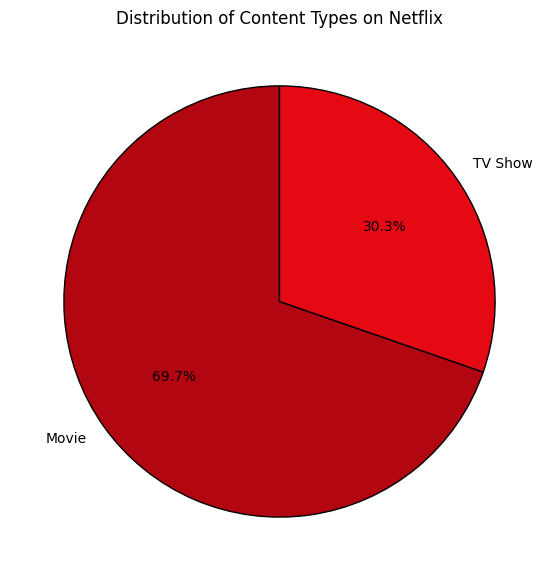

In [4]:
# --- 4. Content Type Ratio (Movie vs. TV Show) ---
print("--- Content Type Counts ---")
type_counts_df = df.groupBy('type').count().orderBy(col("count").desc())
type_counts_df.show()

# Visualize Content Mix
import matplotlib.pyplot as plt
type_pdf = type_counts_df.toPandas()
plt.figure(figsize=(7, 7))
plt.pie(
    type_pdf['count'],
    labels=type_pdf['type'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#b20710', '#e50914'],
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Distribution of Content Types on Netflix')
plt.show()


--- Content Added Per Year ---
+----------+-----+
|year_added|count|
+----------+-----+
|      2008|    2|
|      2009|    2|
|      2010|    1|
|      2011|   13|
|      2012|    3|
|      2013|   11|
|      2014|   24|
|      2015|   82|
|      2016|  429|
|      2017| 1188|
|      2018| 1649|
|      2019| 2016|
|      2020| 1879|
|      2021| 1498|
+----------+-----+



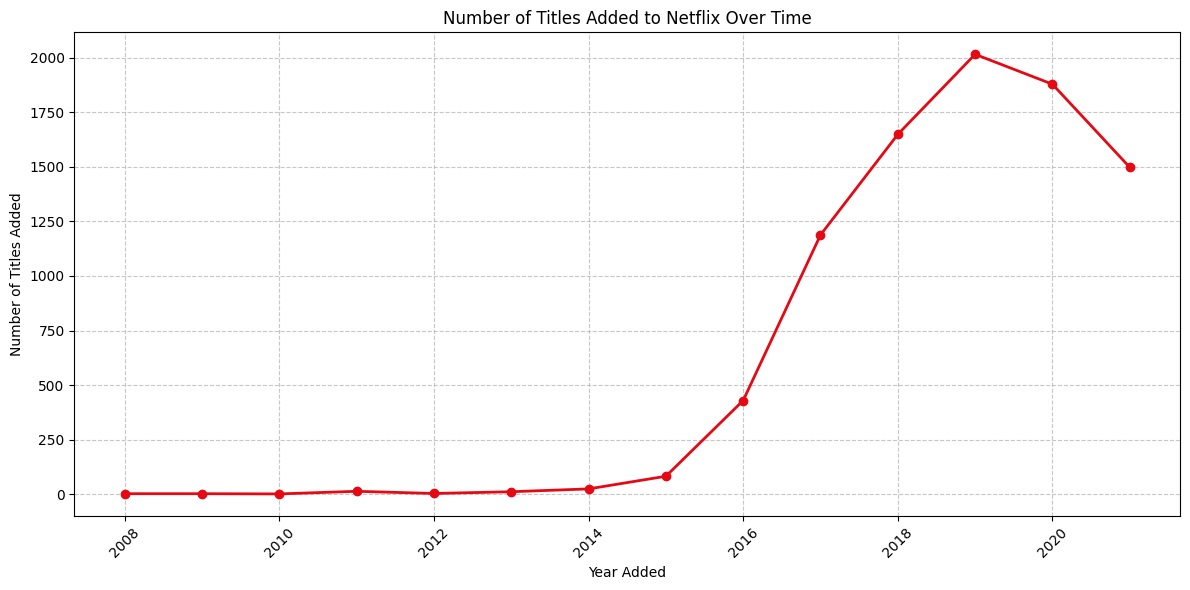

In [5]:
# --- 5. Content Growth Over Time ---
print("--- Content Added Per Year ---")
growth_df = df.groupBy('year_added').count().orderBy('year_added')
growth_df.show()

# Visualize Content Growth
growth_pdf = growth_df.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(
    growth_pdf['year_added'],
    growth_pdf['count'],
    marker='o',
    color='#e50914',
    linewidth=2
)
plt.title('Number of Titles Added to Netflix Over Time')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles Added')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

--- Top 10 Content Producing Countries ---
+--------------+-----+
|single_country|count|
+--------------+-----+
| United States| 3683|
|         India| 1046|
|United Kingdom|  803|
|        Canada|  445|
|        France|  393|
|         Japan|  317|
|         Spain|  232|
|   South Korea|  231|
|       Germany|  226|
|        Mexico|  169|
+--------------+-----+



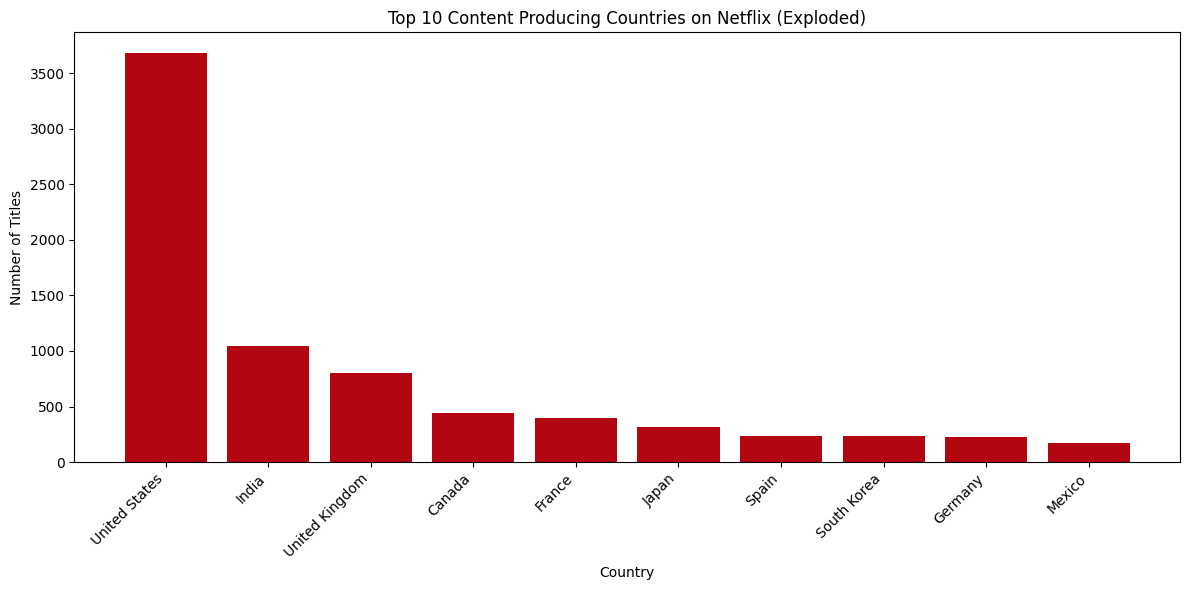

In [6]:
from pyspark.sql.functions import explode, split

# --- 6. Geographic Analysis: Top 10 Producing Countries ---
# Split the string by ', ' and explode the array into new rows (one row per country)
country_df = df.withColumn('single_country', explode(split(col('country'), ', ')))

# Count the occurrences of each country and filter out the 'Unknown' values
top_countries_df = country_df.groupBy('single_country').count()
top_countries_df = top_countries_df.filter(col('single_country') != 'Unknown')
top_10_countries = top_countries_df.orderBy(col("count").desc()).limit(10)

print("--- Top 10 Content Producing Countries ---")
top_10_countries.show()

# Visualize Top Countries
country_pdf = top_10_countries.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(country_pdf['single_country'], country_pdf['count'], color='#b20710')
plt.title('Top 10 Content Producing Countries on Netflix (Exploded)')
plt.xlabel('Country')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



--- Top 10 Genres ---
+--------------------+-----+
|        single_genre|count|
+--------------------+-----+
|International Movies| 2752|
|              Dramas| 2427|
|            Comedies| 1674|
|International TV ...| 1350|
|       Documentaries|  869|
|  Action & Adventure|  859|
|           TV Dramas|  762|
|  Independent Movies|  756|
|Children & Family...|  641|
|     Romantic Movies|  616|
+--------------------+-----+



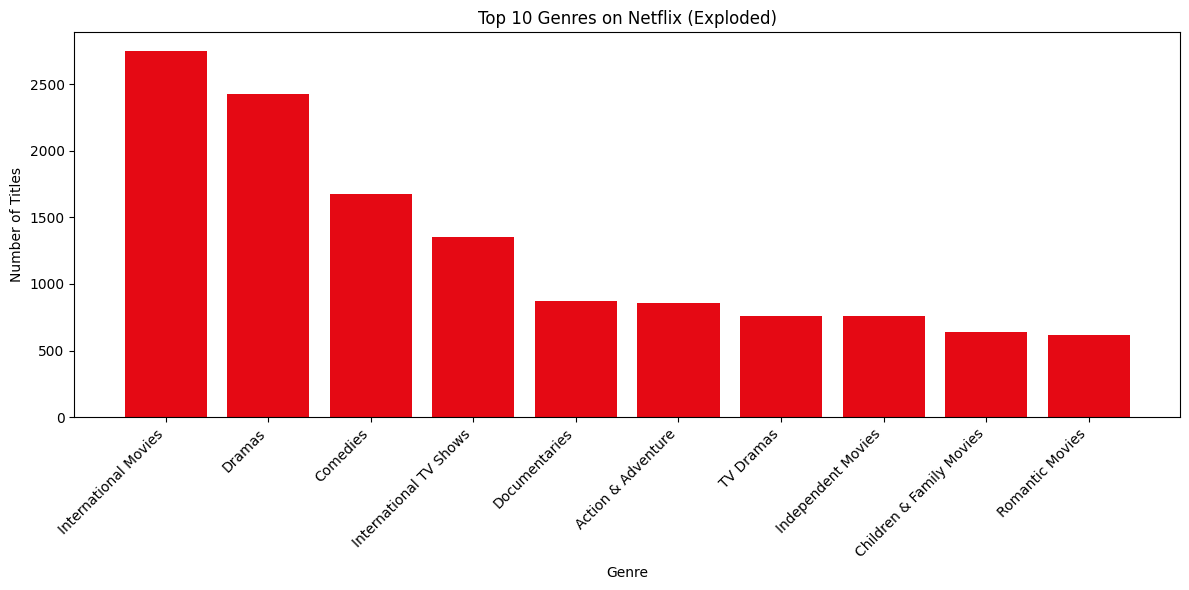

In [7]:
# --- 7. Genre Analysis: Top 10 Genres ---
# Split the string by ', ' and explode the array into new rows (one row per genre)
genre_df = df.withColumn('single_genre', explode(split(col('listed_in'), ', ')))

# Count the occurrences of each genre
top_genres_df = genre_df.groupBy('single_genre').count()
top_10_genres = top_genres_df.orderBy(col("count").desc()).limit(10)

print("--- Top 10 Genres ---")
top_10_genres.show()

# Visualize Top Genres
genre_pdf = top_10_genres.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(genre_pdf['single_genre'], genre_pdf['count'], color='#e50914')
plt.title('Top 10 Genres on Netflix (Exploded)')
plt.xlabel('Genre')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

--- Top Content Ratings ---
+--------------+-----+
|        rating|count|
+--------------+-----+
|         TV-MA| 3205|
|         TV-14| 2157|
|         TV-PG|  861|
|             R|  799|
|         PG-13|  490|
|         TV-Y7|  333|
|          TV-Y|  306|
|            PG|  287|
|          TV-G|  220|
|            NR|   79|
|             G|   41|
|      TV-Y7-FV|    6|
|Unknown Rating|    4|
|            UR|    3|
|         NC-17|    3|
|        84 min|    1|
|        74 min|    1|
|        66 min|    1|
+--------------+-----+



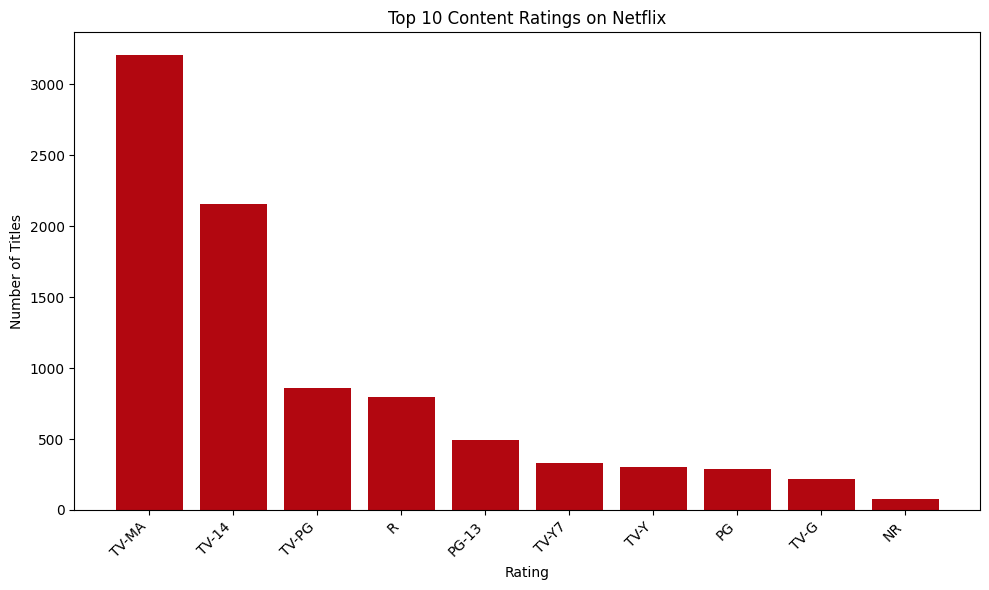

In [8]:
# --- 8. Rating Distribution Analysis ---
print("--- Top Content Ratings ---")
rating_counts_df = df.groupBy('rating').count().orderBy(col("count").desc())
rating_counts_df.show()

# Visualize Top Ratings (using a smaller list for clear visualization)
rating_pdf = rating_counts_df.limit(10).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(rating_pdf['rating'], rating_pdf['count'], color='#b20710')
plt.title('Top 10 Content Ratings on Netflix')
plt.xlabel('Rating')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# --- 9. Stop Spark Session ---
spark.stop()

Dataset Description: Netflix Titles Dataset

The Netflix Titles Dataset contains detailed information about movies and TV shows available on Netflix. It is a structured dataset commonly used for data analysis, visualization, and recommendation system projects. Each record in the dataset represents a unique title on Netflix, including attributes that describe its type, cast, country of origin, release details, and more.

📊 Dataset Overview

This dataset provides insights into Netflix’s global catalog and can be used to explore patterns such as content distribution across countries, genres, and release years.
Typical columns include:

show_id – Unique ID assigned to each show or movie.

type – Indicates whether the title is a Movie or TV Show.

title – Name of the show or movie.

director – Director(s) of the title.

cast – List of main actors involved.

country – Country where the show/movie was produced.

date_added – Date when it was added to Netflix.

release_year – Year the movie or show was originally released.

rating – Age rating (e.g., PG, TV-MA, R, etc.).

duration – Duration in minutes for movies or number of seasons for TV shows.

listed_in – Genres or categories the title belongs to.

description – Short summary of the show or movie’s storyline.

Purpose of the Dataset

This dataset can be used for:

Analyzing Netflix’s content trends over time.

Understanding country-wise content production.

Exploring genre preferences and ratings distribution.

Building recommendation systems based on genre, actors, or ratings.

Performing data visualization and storytelling about Netflix’s global expansion.

📈 Key Insights You Can Derive

Compare the ratio of movies to TV shows.

Identify the most common genres or directors.

Analyze how Netflix’s library has evolved by year.

Study which countries contribute the most content.

Examine audience ratings and age classifications.

🧾 Conclusion

The Netflix Titles dataset provides a comprehensive view of the streaming platform’s content catalog. By analyzing this dataset, one can uncover trends in entertainment production, audience targeting, and Netflix’s global strategy. It serves as an excellent resource for data analysis, visualization, and machine learning projects focused on the entertainment industry.